# UFO observations dataset analysis

In [155]:
import os
import re
import math

import wget as wg
import reverse_geocoder as rg

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap, LogNorm

from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

## Init data

In [107]:

# create directories if not exist
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

data_path = 'data/ufo.csv'
world_map_path = 'data/world.zip'
us_state_map_path = 'data/us_state.zip'
us_state_pop_path = 'data/us_state_pop.csv'
us_state_size_path = 'data/us_state_size.csv'
ufo_mask_path = 'data/ufo_mask.png'


## Don't execute the following cell if you want to manually import the files

In [108]:

# download files if not exist
def download_file(file_path: str) -> None :
    if not os.path.exists(file_path) :
        wg.download(f'https://github.com/pyPoul/ufo-data/raw/refs/heads/master/{file_path}', file_path, bar=None)
        print(f'File \'{file_path}\' downloaded successfully.')
        return
    print(f'File \'{file_path}\' already exists.')

# ufo dataset
download_file(data_path)
# world map
download_file(world_map_path)
# us states map
download_file(us_state_map_path)
# us pop per state in 2010
download_file(us_state_pop_path)
# us state area size
download_file(us_state_size_path)
# ufo image mask
download_file(ufo_mask_path)


File 'data/ufo.csv' already exists.
File 'data/world.zip' already exists.
File 'data/us_state.zip' already exists.
File 'data/us_state_pop.csv' already exists.
File 'data/us_state_size.csv' already exists.
File 'data/ufo_mask.png' downloaded successfully.


## Data loading and cleaning

In [4]:

# load csv file
def load_data(file_path: str) -> pd.DataFrame :
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    return pd.read_csv(file_path)

# save csv file
def save_data(df: pd.DataFrame, file_path: str) -> None :
    df.to_csv(file_path, index=False)

# data info
def get_info(df: pd.DataFrame) -> None :
    print(
        f'Dataset size: {df.shape}\n'
        f'Columns: {df.columns.tolist()}'
    )

# display first rows
def print_first_rows(df: pd.DataFrame | pd.Series, n: int = 5) -> None :
    print(df.head(n))

# save and display plot
def save_and_display_plot(file_path: str) -> None :
    plt.savefig(file_path, dpi=100, bbox_inches='tight')
    plt

# complete missing data
def clean_data(df: pd.DataFrame) -> pd.DataFrame :

    # drop useless columns
    new_df = df.drop(columns=[
        'date posted',
        'duration (hours/min)',
        'city',
    ]).fillna({
        # fill shape unknown when empty
        'shape': 'unknown',
    })

    # rename shapes (merge)
    shape_mapping = {
        'disk': 'circle',
        'round': 'circle',
        'cigar': 'cylinder',
        'changed': 'changing',
        'other': 'unknown',
    }
    new_df['shape'] = new_df['shape'].replace(shape_mapping)

    # convert datetime column to datetime type
    new_df['datetime'] = pd.to_datetime(new_df['datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    new_df['year'] = pd.to_numeric(new_df['datetime'].dt.strftime('%Y'))  # get year
    new_df['month'] = pd.to_numeric(new_df['datetime'].dt.strftime('%m'))  # get month
    new_df['hour'] = pd.to_numeric(new_df['datetime'].dt.strftime('%H'))  # get hour

    # rename columns
    new_df.rename(columns={
        'longitude ': 'longitude',
        'duration (seconds)': 'duration',
    }, inplace=True)

    # format string to numeric and convert to int
    numeric_duration = new_df['duration'].str.extract(r'(\d+)')
    new_df['duration'] = pd.to_numeric(numeric_duration.astype(float).astype('Int64')[0], errors='coerce')
    # set duration to NA if greater than 8 days (too unlikely to be accurate) or negative (invalid)
    new_df.loc[
        (new_df['duration'] > 8 * 60 * 60 * 24) |
        (new_df['duration'] < 0)
        , 'duration'] = pd.NA

    # fill missing country values based on state values
    state_country_mapping = (
        new_df.dropna(subset=['country'])
        .groupby('state')['country']
        .agg(lambda x: x.mode().iat[0])
    )
    # apply the mapping
    new_df['country'] = new_df['country'].fillna(new_df['state'].map(state_country_mapping))

    # fill missing country values based on latitude and longitude
    missing_country_mask = new_df['country'].isna() & new_df['latitude'].notna() & new_df['longitude'].notna()
    # coords list of tuples (latitude, longitude) for rows with missing country
    coords = list(zip(new_df.loc[missing_country_mask, 'latitude'], new_df.loc[missing_country_mask, 'longitude']))
    # get country
    results = rg.search(coords)
    # apply results to missing country values
    new_df.loc[missing_country_mask, 'country'] = [result['cc'].lower() for result in results]  # only country codes

    # convert latitude and longitude to float
    new_df['latitude'] = pd.to_numeric(new_df['latitude'], errors='coerce')
    new_df['longitude'] = pd.to_numeric(new_df['longitude'], errors='coerce')

    return new_df


In [5]:

# load, clean and save data
ufo = load_data(data_path)

print('Original data info:')
get_info(ufo)

# clean data
clean_ufo = clean_data(ufo)

print('\nCleaned data info:')
get_info(clean_ufo)

print('\nFirst 5 rows of cleaned data:')
print_first_rows(clean_ufo[['datetime', 'country', 'state', 'shape', 'duration', 'latitude', 'longitude', 'comments']])

print('\nFirst report of the dataset:')
print(clean_ufo['datetime'].min())

print('\nLast report of the dataset:')
print(clean_ufo['datetime'].max())

# save cleaned data
save_data(clean_ufo, 'data/clean_ufo.csv')

# load maps
world_map = gpd.read_file(world_map_path)
us_map = gpd.read_file(us_state_map_path)

del ufo, data_path


C:\Users\flori\AppData\Local\Temp\ipykernel_13496\205084534.py:5: DtypeWarning: Columns (0: duration (seconds), 1: latitude) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


Original data info:
Dataset size: (80332, 11)
Columns: ['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)', 'duration (hours/min)', 'comments', 'date posted', 'latitude', 'longitude ']
Loading formatted geocoded file...

Cleaned data info:
Dataset size: (80332, 11)
Columns: ['datetime', 'state', 'country', 'shape', 'duration', 'comments', 'latitude', 'longitude', 'year', 'month', 'hour']

First 5 rows of cleaned data:
             datetime country state     shape  duration   latitude  \
0 1949-10-10 20:30:00      us    tx  cylinder      2700  29.883056   
1 1949-10-10 21:00:00      us    tx     light      7200  29.384210   
2 1955-10-10 17:00:00      gb   NaN    circle        20  53.200000   
3 1956-10-10 21:00:00      us    tx    circle        20  28.978333   
4 1960-10-10 20:00:00      us    hi     light       900  21.418056   

    longitude                                           comments  
0  -97.941111  This event took place in early fall around 194...  
1  -

## Shape graphic

In [6]:

# counts shapes
def get_shape_counts(df: pd.DataFrame, *, drop_unknwon: bool = False) -> pd.Series :

    # get shape counts
    vc = df['shape'].value_counts()

    unknown_shapes = vc.pop('unknown')
    # add unknown shapes at the end
    if not drop_unknwon :
        vc['unknown'] = unknown_shapes

    return vc

# display shape counts in a bar graphic
def get_shape_counts_graph(s: pd.Series, ax: Axes, title: str, label: str = '') -> None :

    # plot
    bars = ax.barh(
        s.index[::-1],
        s.values[::-1],
        height=.5,
        color="white",
        edgecolor="black",
    )

    # labels and ticks
    ax.set_title(title, pad=10)
    ax.set_ylabel(f'Shape ({len(s.index)})', labelpad=20, rotation=0)
    ax.yaxis.set_label_coords(-.07, 1.01)  # top left
    ax.tick_params(axis='y', labelsize=9, pad=5)
    ax.set_xlabel(f'Reports number ({sum(s.values)})', labelpad=20)

    # display counts at the end of the bars
    max_value = s.max()
    ax.set_xlim(0, max_value * 1.2)  # extend x-axis to make room for labels
    for bar in bars :
        w = bar.get_width()
        ax.text(
            w + max_value * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f'{w} ({w / sum(s.values) * 100:.1f}%)',  # get percentage
            va='center',
            ha='left',
            fontsize=9,
            alpha=0.7,
        )

    # figure label
    if label != '' :
        ax.text(
            .99, .01,
            label,
            transform=ax.transAxes,
            fontsize=10,
            va='bottom',
            ha='right',
        )


## Shape analysis

**Without `unknown` shapes** (*fig. 1*) **:**

The most common shape is `light` with about **25**% (and up to **36**% if we count `fireball`, `flash` and `flare`), that is more than 2 times the count of the thrid most common shape: `triangle` with about **12**%. The second most common shape is `circle` with about **19**% (but up to **25**% if we count its derivatives `sphere` and `oval`).

**With `unknown` shapes** (*fig. 2*) **:**

The most common shape is still `light` the most common shape with about **21**% (and up to **30**% if we count `fireball`, `flash` and `flare`), but the second most common shape is now `unknown` with about **16.5**% just ahead of `circle` with about **16**% (but up to **27**% if we count its derivatives `sphere` and `oval`). And the `triangle` shape is now the fourth most common shape with about **10**%.

We also have extremely rare shapes such as `pyramid` and `hexagon` with less than **10** observations each.


The 3 most common shapes are:
shape
light       16565
circle      12823
triangle     7865
Name: count, dtype: int64


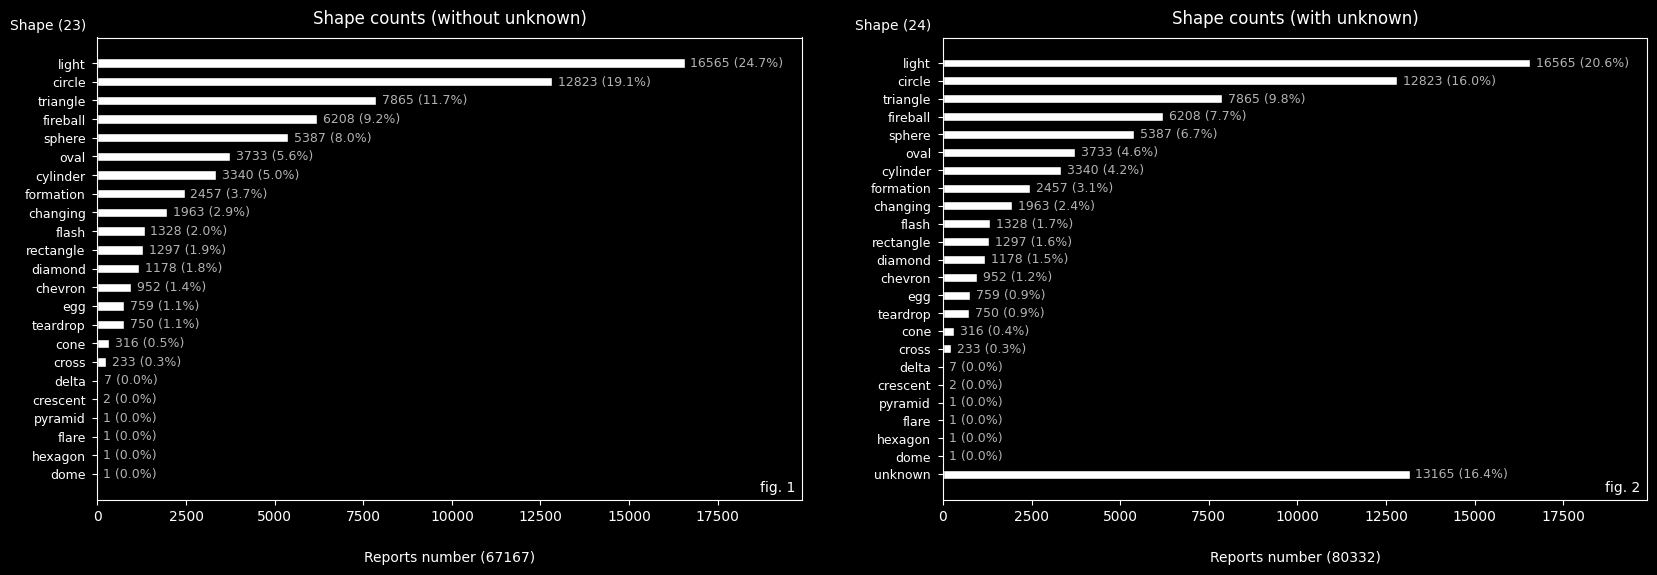

In [7]:

# get shape counts
shape_counts_full = get_shape_counts(clean_ufo)
shape_counts      = get_shape_counts(clean_ufo, drop_unknwon=True)

print('The 3 most common shapes are:')
print_first_rows(shape_counts_full, 3)

# display shape counts in a bar graphic with and without unknown shapes
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
get_shape_counts_graph(shape_counts,      ax1, 'Shape counts (without unknown)', 'fig. 1')
get_shape_counts_graph(shape_counts_full, ax2, 'Shape counts (with unknown)',    'fig. 2')

# save and display graphic
save_and_display_plot('results/shape_counts.png')

del ax1, ax2, shape_counts, shape_counts_full


## Temporal graphic

In [33]:
seasons: dict[str, tuple[int, int, int]] = {
    'winter': (12, 1, 2),
    'spring': (3, 4, 5),
    'summer': (6, 7, 8),
    'autumn': (9, 10, 11),
}

day_parts: dict[str, set[int]] = {
    'night': set(range(0, 6)) | set(range(22, 24)),
    'morning': set(range(6, 12)),
    'afternoon': set(range(12, 18)),
    'evening': set(range(18, 22)),
}

# counts years
def get_year_counts(df: pd.DataFrame) -> pd.Series :
    new_df = df['year'].value_counts().sort_index()
    # add missing years with 0 counts
    return new_df.reindex(np.arange(new_df.index.min(), new_df.index.max() + 1), fill_value=0)

# seasons counts
def get_season_counts(df: pd.DataFrame) -> pd.Series :

    return pd.cut(
        df['month'],
        bins=[1, 3, 6, 9, 12, 13],
        labels=['winter', 'spring', 'summer', 'autumn', 'winter'],
        right=False,
        include_lowest=True,
        ordered=False,
    ).value_counts().reindex([
        'winter',
        'spring',
        'summer',
        'autumn',
    ])

# day parts counts
def get_day_part_counts(df: pd.DataFrame) -> pd.Series :

    return pd.cut(
        df['hour'],
        bins=[0, 6, 12, 18, 22, 24],
        labels=['night', 'morning', 'afternoon', 'evening', 'night'],
        right=False,
        include_lowest=True,
        ordered=False,
    ).value_counts().reindex([
        'night',
        'morning',
        'afternoon',
        'evening',
    ])

# display year counts in a line graphic
def get_year_counts_graph(s: pd.Series, ax: Axes, title: str, label: str = '', *, all_x_tick_labels: bool = False, ylabel: str | None = None) -> None :

    # plot
    ax.plot(
        s.index,
        s.values,
        drawstyle='default',
        color='white',
    )

    if all_x_tick_labels :
        ax.set_xticks(s.index)
    else :
        # set x-ticks to every 5 years, including the first and last year
        y_min, y_max = s.index.min(), s.index.max()
        start = math.ceil(y_min / 5) * 5  # round up to nearest multiple of 5
        x_ticks = [y_min] + [year for year in range(start, y_max, 5)] + [y_max]
        ax.set_xticks(x_ticks)

    # labels and ticks
    ax.set_title(title, pad=10)
    ax.set_xlabel(f'Year', labelpad=20)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylabel(ylabel or f'Reports number ({sum(s.values)})', labelpad=20, rotation=0)
    ax.yaxis.set_label_coords(-.08, 1.01)  # top left

    # figure label
    if label != '' :
        ax.text(
            .99, .01,
            label,
            transform=ax.transAxes,
            fontsize=10,
            va='bottom',
            ha='right',
        )

# display season and day part counts in a bar graphic
def get_bars_graph(s: pd.Series, ax: Axes, title: str, label: str = '', *, display_count: bool = True, xlabel: str | None = None, ylabel: str | None = None, start: int = 0, end: int | None = None) -> None :

    # take series length if end is None or greater than series length
    limit: int = min(end or len(s), len(s))

    # plot
    bars = ax.bar(
        s.index[start:limit],
        s.values[start:limit],
        color="white",
        edgecolor="black",
    )

    # labels and ticks
    ax.set_title(title, pad=10)
    ax.set_xlabel(f'{xlabel or s.index.name}', labelpad=20)
    ax.set_ylabel(ylabel or f'Reports number ({sum(s.values)})', labelpad=20, rotation=0)
    ax.yaxis.set_label_coords(-.08, 1.01)  # top left

    # display counts at the end of the bars
    if display_count :
        max_value = s[start:].max()
        ax.set_ylim(0, max_value * 1.2)  # extend y-axis to make room for labels
        for bar in bars :
            h = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                h + max_value * 0.01,
                f'{h} ({h / sum(s.values) * 100:.1f}%)',
                va='bottom',
                ha='center',
                fontsize=9,
                alpha=0.7,
            )

    # figure label
    if label != '' :
        ax.text(
            .99, .01,
            label,
            transform=ax.transAxes,
            fontsize=10,
            va='bottom',
            ha='right',
        )


## Temporal analysis

**Analysis by year** (*fig. 1* and *fig. 2*) **:**

The number of UFO sightings is fairly stable between `1945` and `1994` with an average of about **154** reports per year, then there is a significant increase starting from `1995` (**1078**) up to the maximum number of reports in `2012` (**7356**), with a slight decrease in `2013` (**7038**). This increase may be due to several factors, such as improvements in communication technology (internet, smartphones, ...) and/or greater public awareness of unexplained aerial phenomena (and more broadly science fiction) through movies (Alien, Independence Day, ...), TV series (X-Files, ...). The average number of reports has therefore exploded from `1995` onwards with approximately **3700** reports until `2013`, which is more than 20 times the previous average.

**Analysis by season** (*fig. 3*) **:**

The most common season for UFO sightings is summer with about **33**% of reports, followed by autumn with about **27**% and spring and winter with about **19**% each. This may be due to several factors, such as more favorable weather conditions in summer (clearer skies, more light, ...) and/or greater outdoor human activity during this season (vacations, festivals, ...).

**Analysis by day part** (*fig. 4*) **:**

The most common part of the day for UFO sightings is night (10pm-6am) with about **43**% of reports, closely followed by evening (6pm-10pm) with about **37**% of reports, then afternoon with **12**% and morning with only **7**% of reports. This may be due to several factors, such as more favorable visibility conditions at night (less light, more contrast: which coincides with the great popularity of luminous shapes observed) and/or greater outdoor human activity in the evening (outings, ...), while morning and afternoon are times when people are often busy with their daily activities (work, school, ...).

Average reports per year (1945-1994): 154

Average reports per year (1995-2013): 3700

Average reports per year (1945-2013): 1130

The 3 years with the most reports are:
year
2012    7356
2013    7038
2011    5107
Name: count, dtype: int64


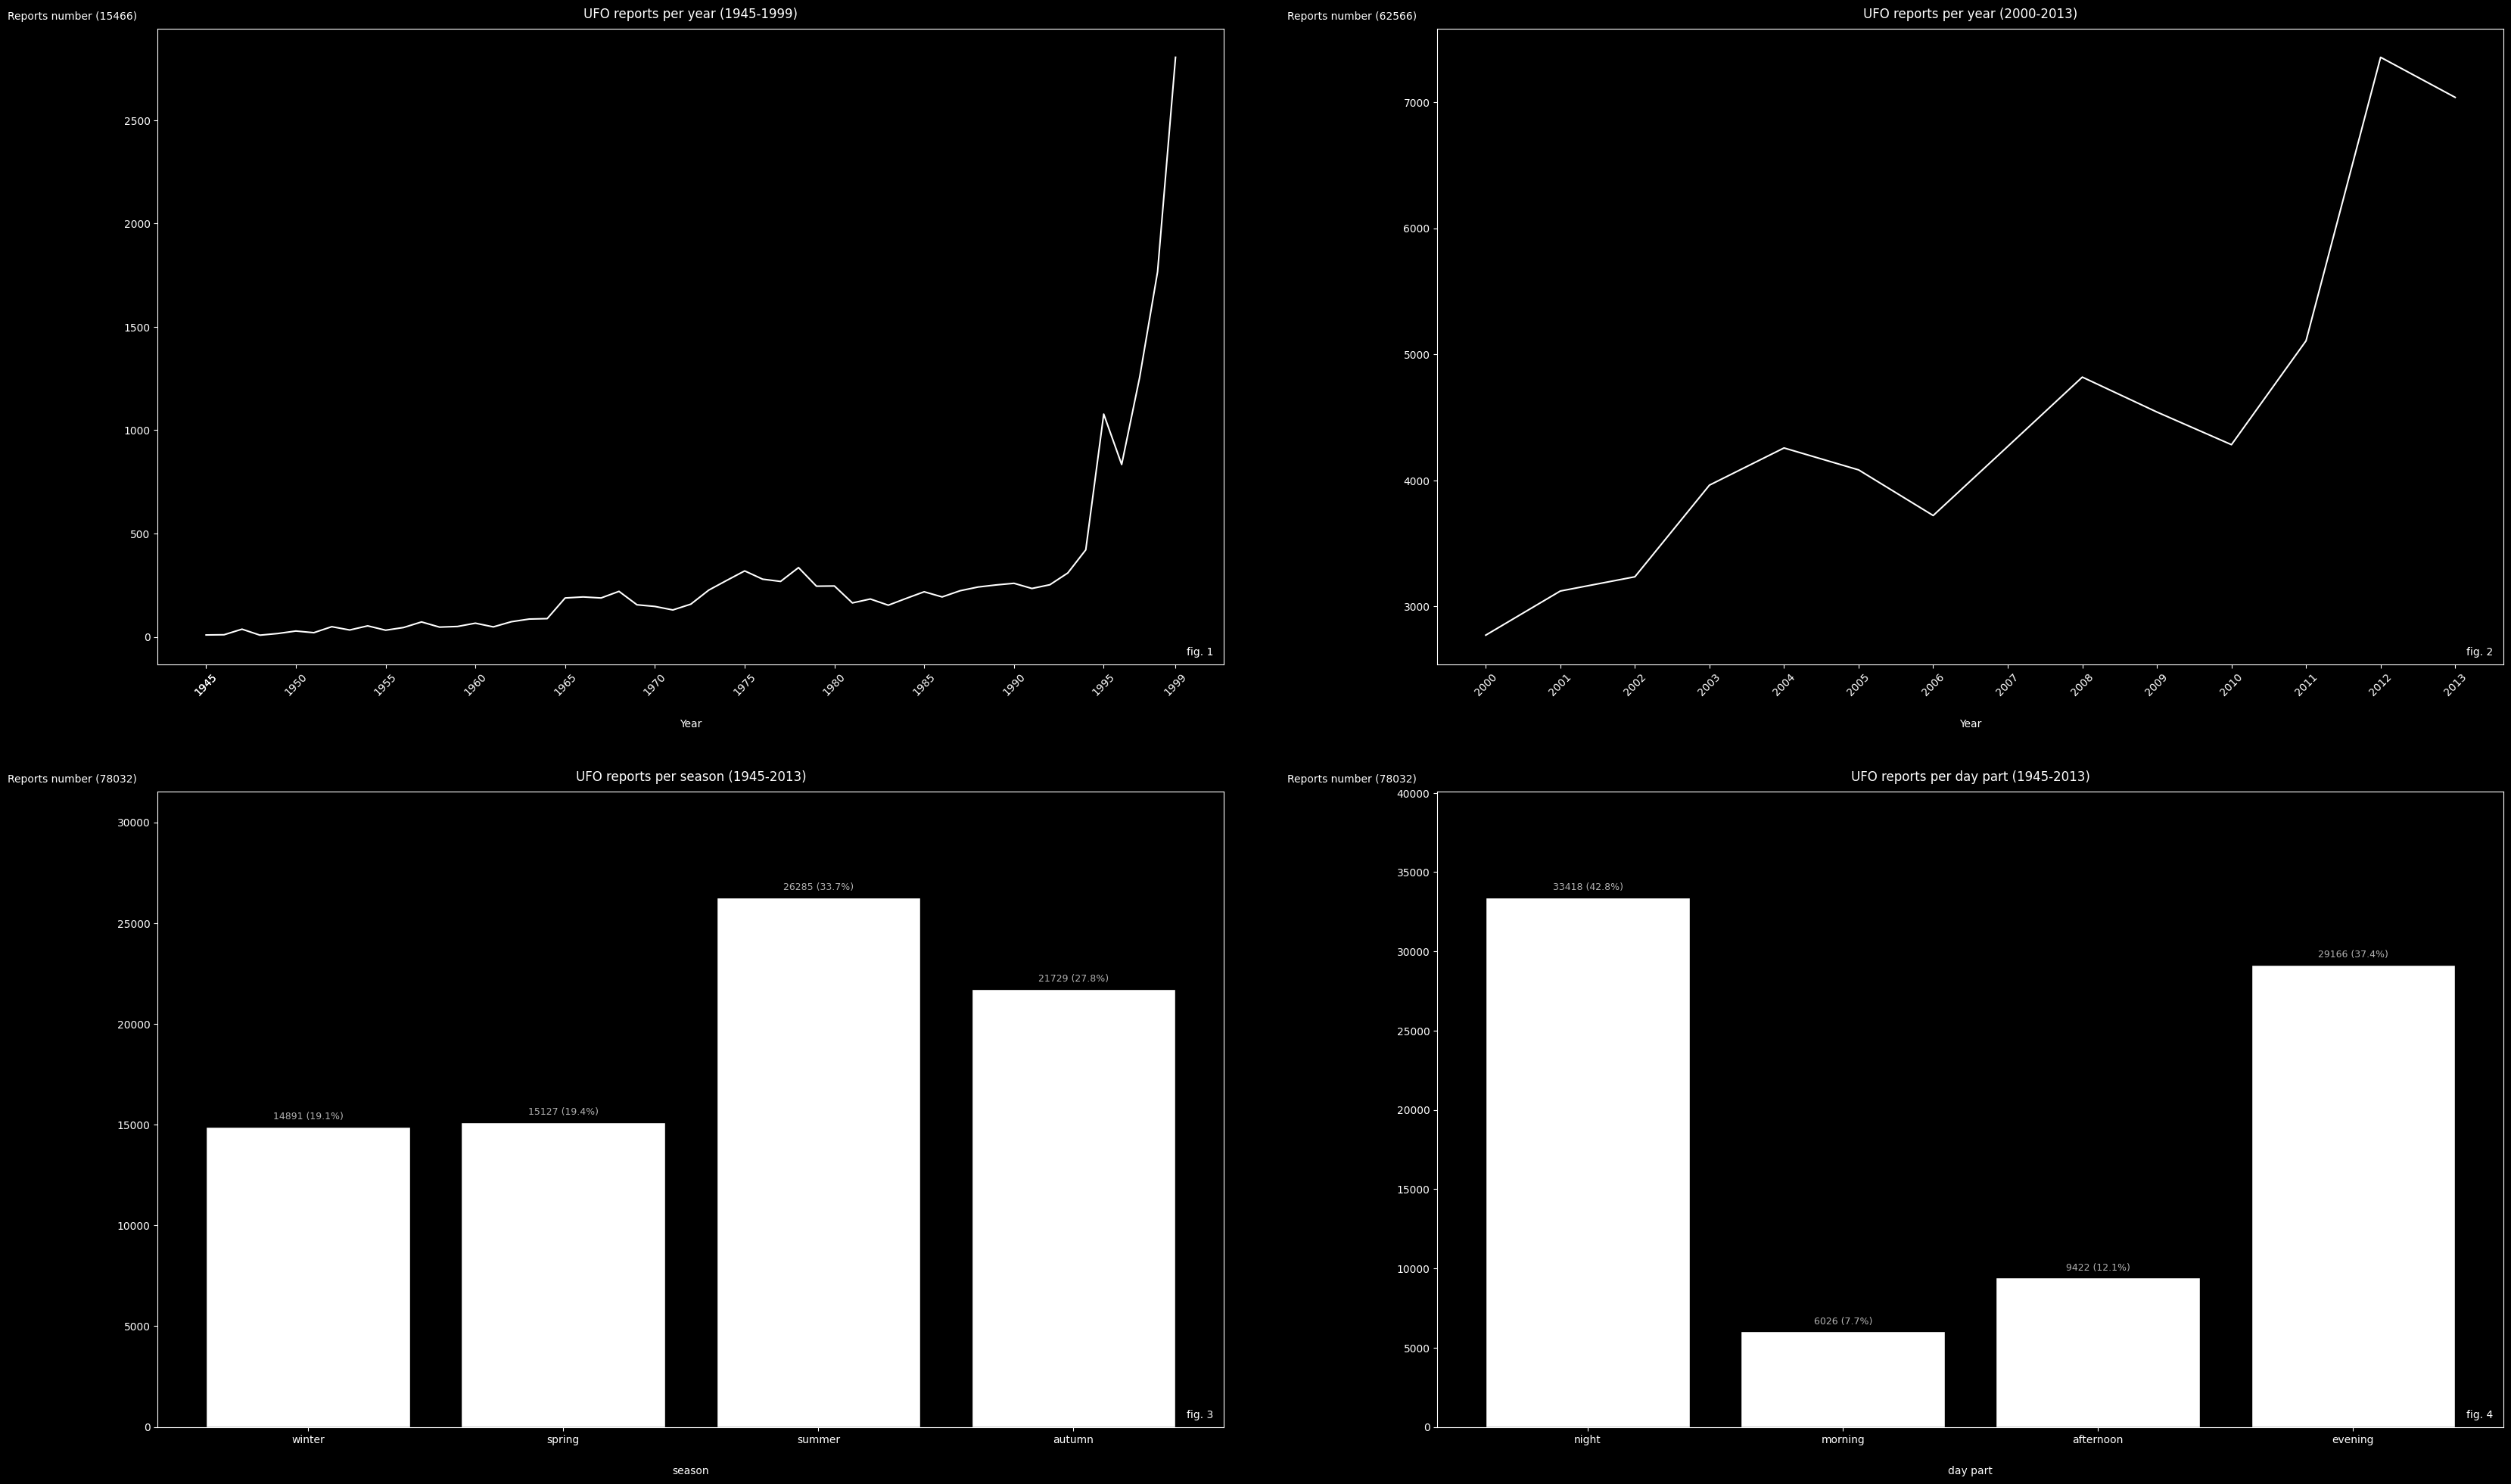

In [9]:

# keep only report between 1945 and 2013
clean_datetime_ufo = clean_ufo[
    (clean_ufo.year >= 1945) &
    (clean_ufo.year < 2014)
]

# get year, season and day part counts
year_counts = get_year_counts(clean_datetime_ufo)
season_counts = get_season_counts(clean_datetime_ufo)
day_parts_counts = get_day_part_counts(clean_datetime_ufo)

# average reports per year
print(
    'Average reports per year (1945-1994):',
    year_counts[year_counts.index < 1995].mean().__int__()
)
print(
    '\nAverage reports per year (1995-2013):',
    year_counts[year_counts.index >= 1995].mean().__int__()
)

print(
    '\nAverage reports per year (1945-2013):',
    year_counts.mean().__int__()
)

print('\nThe 3 years with the most reports are:')
print_first_rows(year_counts.sort_values(ascending=False), 3)

# init subplots
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(40, 24))

# years counts (1945-1999) graphic
get_year_counts_graph(
    year_counts[year_counts.index < 2000],
    ax1,
    f'UFO reports per year (1945-1999)',
    'fig. 1'
)

# years counts (2000-2013) graphic
get_year_counts_graph(
    year_counts[year_counts.index >= 2000],
    ax2,
    f'UFO reports per year (2000-2013)',
    'fig. 2',
    all_x_tick_labels=True,
)

# season counts graphic
get_bars_graph(
    season_counts,
    ax3,
    'UFO reports per season (1945-2013)',
    'fig. 3',
    xlabel='season',
)

# day part counts graphic
get_bars_graph(
    day_parts_counts,
    ax4,
    'UFO reports per day part (1945-2013)',
    'fig. 4',
    xlabel='day part'
)

# save and display graphic
save_and_display_plot('results/temporal.png')

del year_counts, season_counts, day_parts_counts
del ax1 ,ax2, ax3, ax4


## Geographical graphic

In [10]:

# get ufo reports per country
def get_country(df: pd.DataFrame | gpd.GeoDataFrame, country: str, *, drop: bool = True) -> pd.DataFrame | gpd.GeoDataFrame :
    new_df = df[df['country'] == country]
    if drop :
        new_df.drop(columns=['country'], inplace=True)
    return new_df

# get country counts
def get_country_counts(df: pd.DataFrame) -> pd.Series :
    return df['country'].value_counts()

# get US states counts
def get_us_states_counts(df: pd.DataFrame) -> pd.Series :
    return df[df['country'] == 'us']['state'].value_counts()

# convert dataframe to geodataframe
def get_geo_df(df: pd.DataFrame) -> gpd.GeoDataFrame :

    notna = df[df['latitude'].notna() & df['longitude'].notna()]  # if latitude and longitude are not NA
    return gpd.GeoDataFrame(
        notna,
        geometry=gpd.points_from_xy(
            notna['longitude'], notna['latitude']
        )
    )

# get states counts proportions
def get_state_counts_prop(us_counts: pd.Series) -> pd.DataFrame :

    # get US state population
    us_states_pop = load_data(us_state_pop_path)
    us_states_pop['state'] = us_states_pop['state'].str.lower()

    # get US state area size
    us_states_size = load_data(us_state_size_path)
    us_states_size['state'] = us_states_pop['state'].str.lower()

    # merge both dataframes
    ussp = pd.merge(us_states_pop, us_states_size, on='state', how='left')

    # calc nb of state reports per 1M inhabitants
    ussp['counts_per_capita'] = ussp['state'].map(us_counts).div(ussp['pop'].div(1e6)).round(2)
    # calc nb of state reports per hectare
    ussp['counts_per_hectare'] = ussp['state'].map(us_counts).div(ussp['size'].div(1e4)).round(2)

    # calc z-score between population and area size
    ussp['z_pop'] = (ussp['counts_per_capita'] - ussp['counts_per_capita'].mean()) / ussp['counts_per_capita'].std(ddof=0)
    ussp['z_size'] = (ussp['counts_per_hectare'] - ussp['counts_per_hectare'].mean()) / ussp['counts_per_hectare'].std(ddof=0)
    ussp['z_score'] = ussp[['z_pop', 'z_size']].mean(axis=1)

    # sort states with the z-score
    ussp.sort_values('z_score', ascending=False, inplace=True)

    # drop columns
    ussp.drop(columns=[
        'z_pop',
        'z_size',
        'z_score',
    ], inplace=True)

    return ussp

# place points on map
def place_points_on_map(gdf: gpd.GeoDataFrame, map: gpd.GeoDataFrame, ax: Axes, dot_size: float, title: str, label: str = '', *, zoom_in: dict | None = None) -> None :

    # plot map
    map.plot(
        ax=ax,
        color='white',
        edgecolor='black',
    )
    ax.set_title(title, pad=10)
    # remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # plot points
    gdf.plot(
        ax=ax,
        color='red',
        alpha=.8,
        markersize=dot_size,
        rasterized=True,
    )

    if label != '' :
        ax.text(
            .99, .01,
            label,
            transform=ax.transAxes,
            fontsize=10,
            va='bottom',
            ha='right',
        )

    # zoom on specific country if requested
    if zoom_in is not None :
        ax.set_xlim(zoom_in['longitude'])
        ax.set_ylim(zoom_in['latitude'])

        # add insets for Alaska and Hawaii if zooming on US
        if zoom_in.get('country') == 'us':
            # filter data for Alaska
            gdf_alaska = gdf[gdf['state'] == 'ak']

            # filter data for Hawaii
            gdf_hawaii = gdf[gdf['state'] == 'hi']

            # alaska inset
            ax_alaska = inset_axes(
                ax, width="20%", height="20%", loc='lower left',  # 20% of the main plot size
                bbox_to_anchor=(0.01, 0.02, 1, 1), bbox_transform=ax.transAxes
            )
            map.plot(ax=ax_alaska, color='white', edgecolor='black')
            if len(gdf_alaska) > 0:
                gdf_alaska.plot(ax=ax_alaska, color='red', alpha=.8, markersize=dot_size, rasterized=True)
            # set limits to focus on Alaska
            ax_alaska.set_xlim(-180, -130)
            ax_alaska.set_ylim(51, 72)
            # remove axis and border
            ax_alaska.set_axis_off()

            # hawaii inset
            ax_hawaii = inset_axes(
                ax, width="20%", height="20%", loc='lower left',  # 20% of the main plot size
                bbox_to_anchor=(0.21, 0.02, 1, 1), bbox_transform=ax.transAxes
            )
            map.plot(ax=ax_hawaii, color='white', edgecolor='black')
            if len(gdf_hawaii) > 0:
                gdf_hawaii.plot(ax=ax_hawaii, color='red', alpha=.8, markersize=dot_size, rasterized=True)
            # set limits to focus on Hawaii
            ax_hawaii.set_xlim(-161, -154)
            ax_hawaii.set_ylim(18, 23)
            # remove axis and border
            ax_hawaii.set_axis_off()

# display us states counts proportions in a bar graphic
def get_us_prop(df: pd.DataFrame, ax: Axes, title: str, label: str = '') -> None :

    # title
    ax.set_title(title, pad=10)

    x = np.arange(len(df))
    w = .4

    # first bar per state
    bar1 = ax.bar(x - w/2, df['counts_per_capita'], w, label='reports per capita', color='steelblue')
    ax.set_ylabel('Number of reports per 1M inhabitants', color='tab:blue', labelpad=10)
    ax.tick_params(axis='y', labelcolor='tab:blue')

    ax.set_xlabel('state', labelpad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(df['state'], fontsize=12)

    # second bar per state
    ax0 = ax.twinx()
    bar2 = ax0.bar(x + w/2, df['counts_per_hectare'], w, label='reports per size', color='darkorange')
    ax0.set_ylabel('Number of reports per hectare (10k km²)', color='tab:orange', labelpad=10)
    ax0.tick_params(axis='y', labelcolor='tab:orange')

    # legend
    max_count = max(df['counts_per_capita'].max(), df['counts_per_hectare'].max())
    ax.set_ylim(0, max_count * 1.1)
    ax0.set_ylim(0, max_count * 1.1)
    ax.legend([bar1[0], bar2[0]], [ax.get_ylabel(), ax0.get_ylabel()], loc='upper right', fontsize=12)

    # display count at the end of the blue bar
    for bar in bar1 :
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2 - .05,
            h + df['counts_per_capita'].max() * 0.02,
            f'{h}',
            va='bottom',
            ha='center',
            fontsize=7,
            rotation=90,
            color='steelblue',
        )

    # display count at the end of the orange bar
    for bar in bar2 :
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2 + .05,
            h + df['counts_per_hectare'].max() * 0.02,
            f'{h}',
            va='bottom',
            ha='center',
            fontsize=7,
            rotation=90,
            color='darkorange',
        )

    # figure label
    if label != '' :
        ax.text(
            .99, .01,
            label,
            transform=ax.transAxes,
            fontsize=10,
            va='bottom',
            ha='right',
        )


## Geographical analysis

**Analysis by country** (*fig. 1* and *fig. 2*) **:**

The country with the most reports, by far, is the United States with approximately **88**% (**68885**) of the reports (nearly 20 times more than Canada). If we exclude the United States, the next 3 countries with the most reports are Canada with approximately **45**% of the remaining reports, the United Kingdom with approximately **30**% of the reports, and Australia with approximately **8**% of the reports. We note that English-speaking countries are largely dominant in the reports, which may be due to several factors, such as the popularity of science fiction in these countries, greater public awareness of unexplained aerial phenomena, or the widespread use of English in the media and social networks, thereby facilitating the dissemination of reports. We also note that countries close to the aforementioned English-speaking countries also have a significant number of reports, such as Mexico (**3**%) for the United States, or the Netherlands (**1.5**%) and Germany (**1.7**%) for the United Kingdom.

**Analysis by US state** (*fig. 3*) **:**

The US state with the most reports, by far, is California with approximately **13**% (**9373**) of the reports, which is more than 2 times the number of the second state: Washington with **4170** reports, followed by Florida and Texas with **3956** and **3607** reports respectively. Most of the reports are concentrated in major cities and in the most densely populated areas, notably in the northeastern United States as well as along the entire west coast.

**Analysis by US state based on population (2010)** (*fig. 4*) **:**

California, although the state with the most reports, accounts for only **251** reports per million inhabitants, placing it **18th**, as it is the most populous state. The 3 states with the most reports per million inhabitants are Washington, Montana, and Vermont with **620**, **496**, and **479** reports respectively.

**Analysis by US state based on area** (*fig. 4*) **:**

California, although the state with the most reports, accounts for only **221** reports per hectare, placing it **10th**, as it is the third-largest state in the United States. The state with the most reports per hectare is Rhode Island with **707** reports, being the smallest state in the United States with only 4000 km². The second and third states with the most reports per hectare are Connecticut (third-smallest state) and New Jersey (fourth-smallest state) with **661** and **650** reports respectively.

The country with the most reports is: us with 68885 reports (88.28%).

The next 3 countries with the most reports are:
country
ca    3543
gb    2355
au     616
Name: count, dtype: int64

The state with the most reports is: ca with 9373 reports (13.62%).

The next 10 US states with the most reports are:
state
wa    4170
fl    3956
tx    3607
ny    3161
il    2615
az    2580
pa    2515
oh    2363
mi    2036
nc    1797
Name: count, dtype: int64

The 10 states with the most reports per million inhabitants are:
   state  counts_per_capita
46    wa             620.12
25    mt             496.25
44    vt             479.43
36    or             466.19
18    me             465.23
1     ak             461.82
2     az             403.63
28    nh             391.20
30    nm             374.91
49    wy             356.62

The 10 states with the most reports per hectare are:
   state  counts_per_hectare
38    ri              707.32
6     ct              661.00
29    nj              650.70
20    ma  

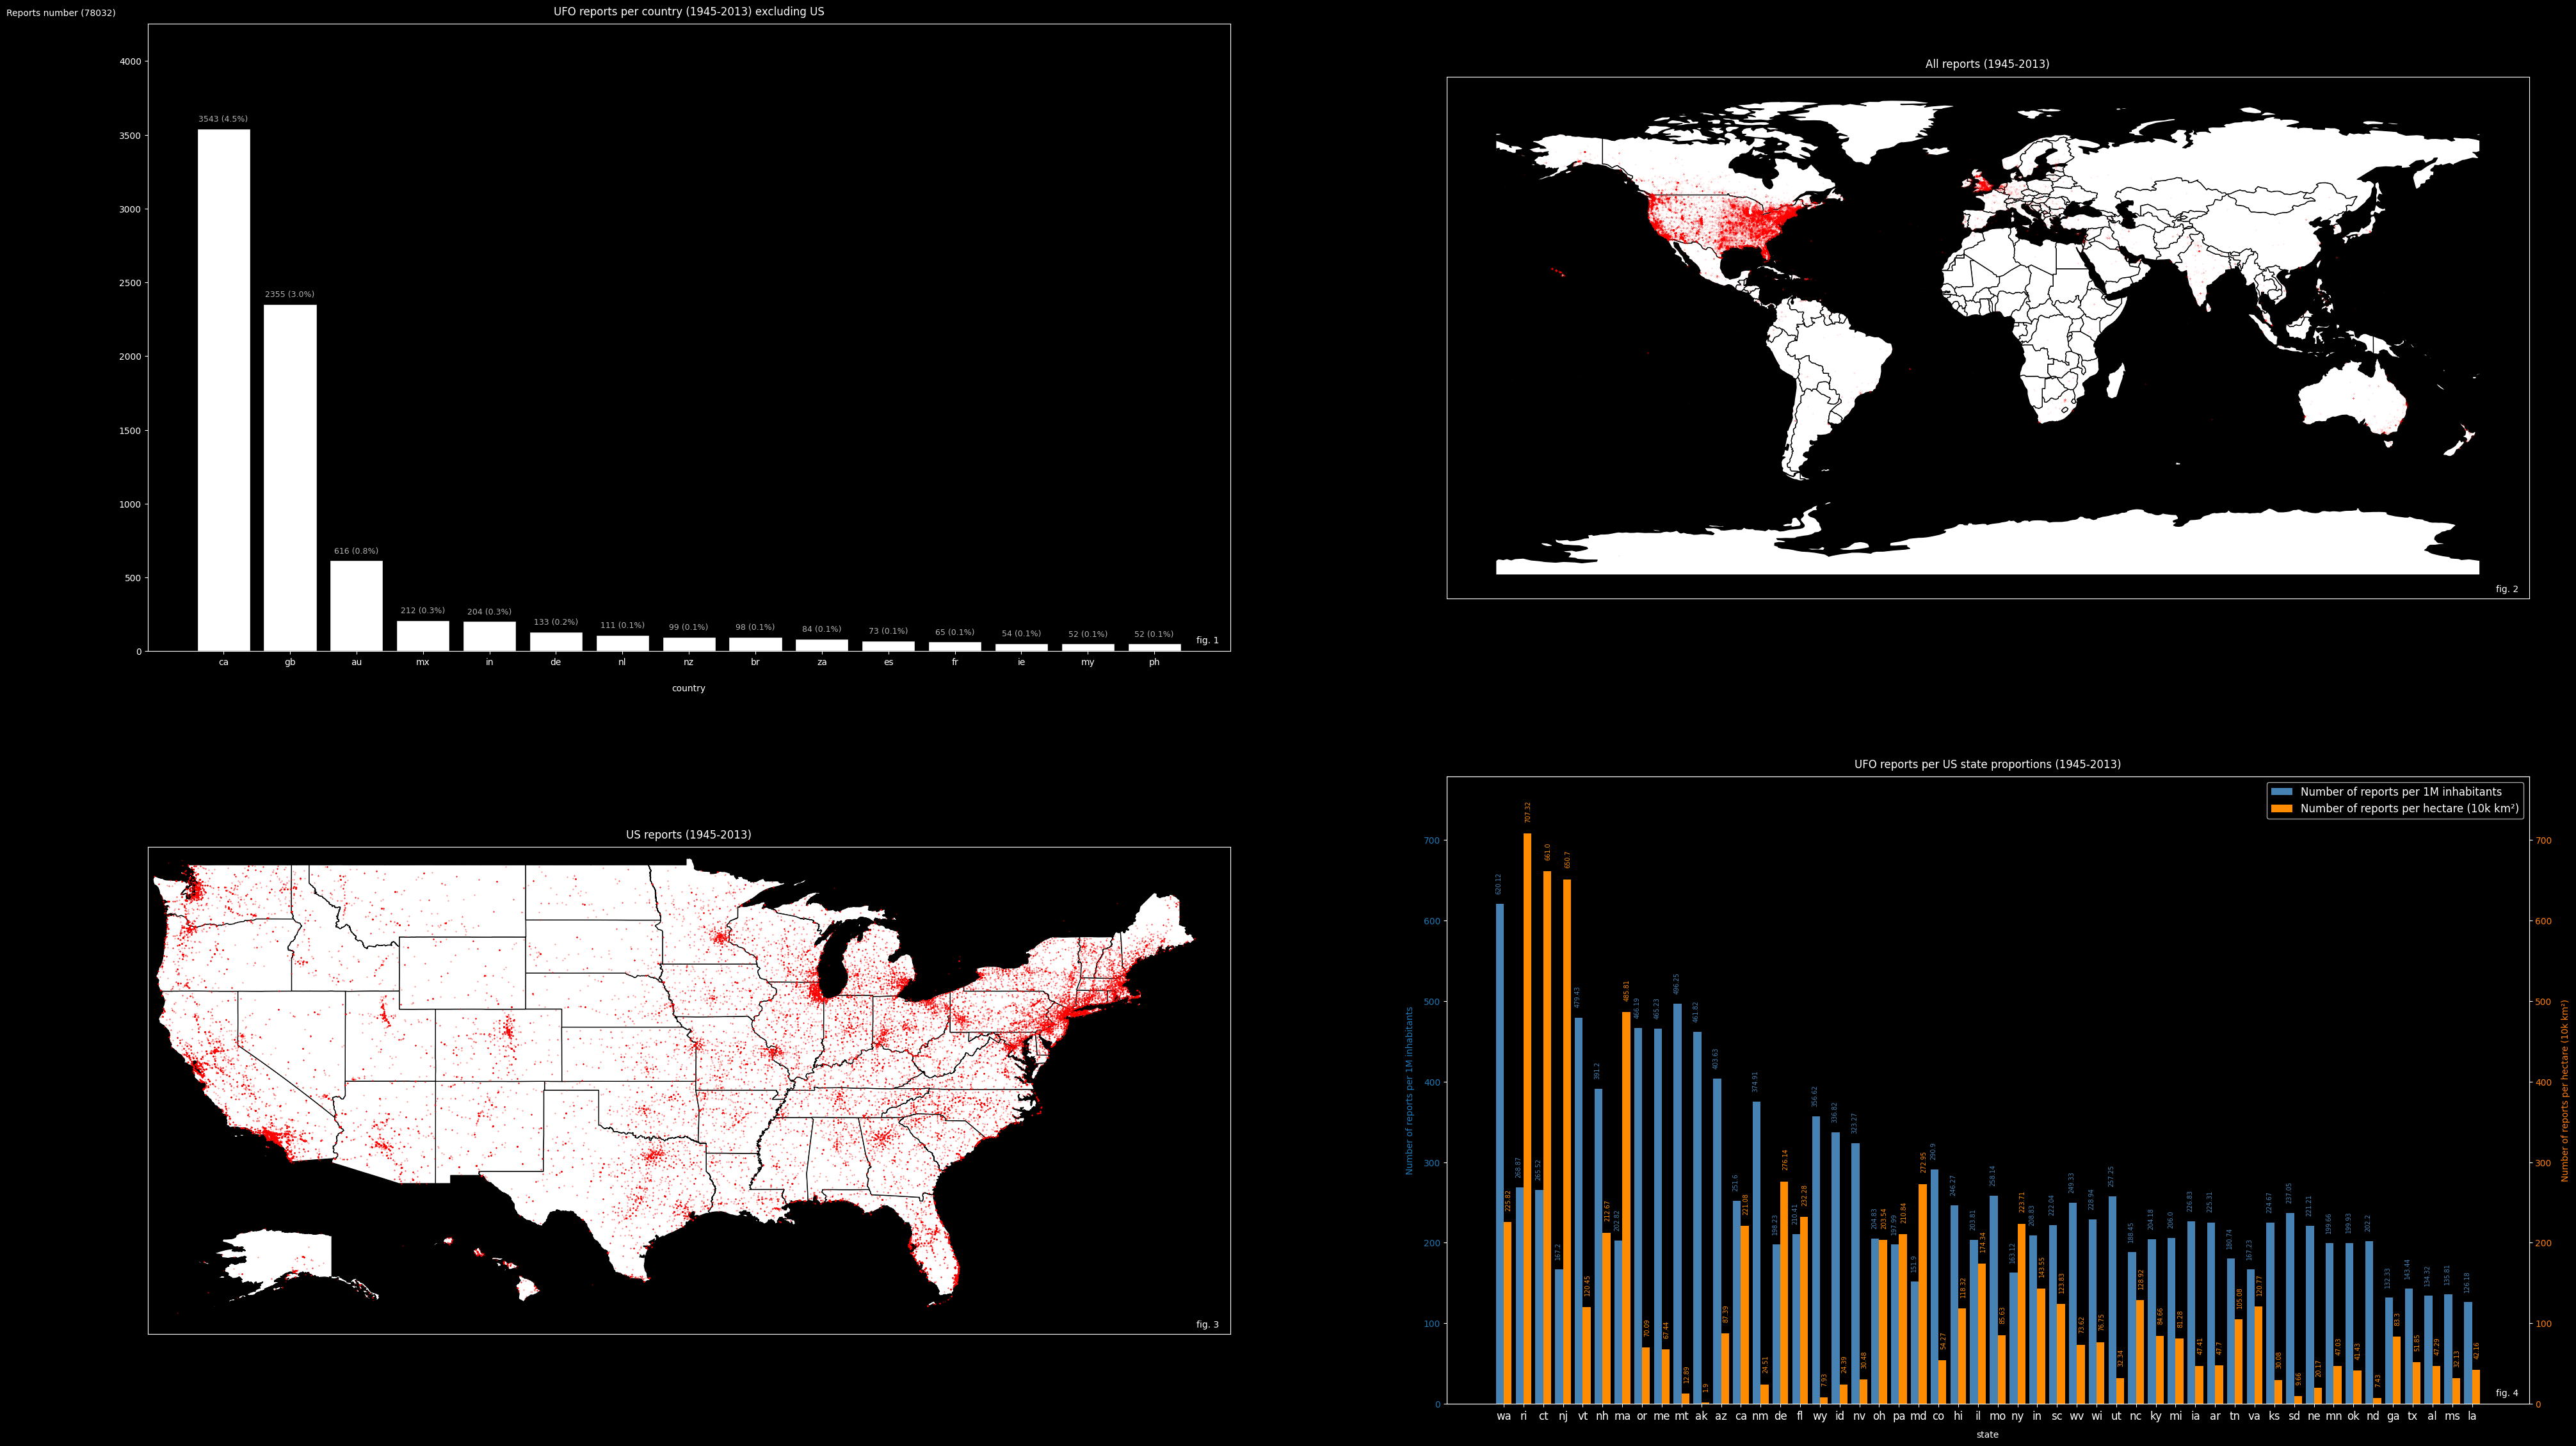

In [22]:

# define zoom areas for specific countries
zoom_in = {
    'us': {
        'country': 'us',
        'longitude': (-125, -65),
        'latitude': (23, 50),
    },
}

# get geodataframe
df_geo = get_geo_df(clean_datetime_ufo)
# get country counts
country_counts = get_country_counts(clean_datetime_ufo)
# get US reports geodataframe
us_geo_df = get_country(df_geo, 'us')
# get US states counts
us_states_counts = get_us_states_counts(clean_datetime_ufo)
# get US states counts proportions
us_states_counts_props = get_state_counts_prop(us_states_counts)

print(f'The country with the most reports is: {country_counts.index[0]} with {country_counts.values[0]} reports ({country_counts.values[0] / country_counts.values.sum() * 100 :.2f}%).')
print('\nThe next 3 countries with the most reports are:')
print_first_rows(country_counts[1:], 3)

print(f'\nThe state with the most reports is: {us_states_counts.index[0]} with {us_states_counts.values[0]} reports ({us_states_counts.values[0] / us_states_counts.values.sum() * 100 :.2f}%).')
print('\nThe next 10 US states with the most reports are:')
print_first_rows(us_states_counts[1:], 10)

print('\nThe 10 states with the most reports per million inhabitants are:')
print_first_rows(us_states_counts_props[['state', 'counts_per_capita']].sort_values('counts_per_capita', ascending=False), 10)

print('\nThe 10 states with the most reports per hectare are:')
print_first_rows(us_states_counts_props[['state', 'counts_per_hectare']].sort_values('counts_per_hectare', ascending=False), 10)

# create subplots
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(48, 28))

# country counts graphic
get_bars_graph(
    country_counts,
    ax1,
    'UFO reports per country (1945-2013) excluding US',
    'fig. 1',
    start=1,  # exclude US (the most common country with 88% of reports)
    end=16,  # keep the next 15 countries
)

# place points on world map graphic
place_points_on_map(
    df_geo,
    world_map,
    ax2,
    .005,
    'All reports (1945-2013)',
    'fig. 2',
)

# place points on US map graphic
place_points_on_map(
    us_geo_df,
    us_map,
    ax3,
    .1,
    'US reports (1945-2013)',
    'fig. 3',
    zoom_in=zoom_in['us'],
)

# US states counts per capita graphic
get_us_prop(
    us_states_counts_props,
    ax4,
    'UFO reports per US state proportions (1945-2013)',
    'fig. 4',
)

# save and display
save_and_display_plot('results/geographical.png')

del country_counts, us_geo_df, us_states_counts, us_states_counts_props
del ax1, ax2, ax3, ax4


## Duration graphics

In [26]:

# get median for each year
def get_duration_by_year(gdf: gpd.GeoDataFrame) -> pd.Series :
    return gdf.groupby('year')['duration'].median().round(2)

# place points on map
def place_durations_on_map(gdf: gpd.GeoDataFrame, map: gpd.GeoDataFrame, ax: Axes, title: str, label: str = '') -> None :

    # normalize size (0.001 - 0.05) and alpha with year
    min_size, max_size = .01, 1.
    min_year, max_year = gdf['year'].min(), gdf['year'].max()
    size_norm = LogNorm(vmin=min_year, vmax=max_year)
    alphas = size_norm(gdf['year'])
    sizes = alphas * (max_size - min_size) + min_size

    # normalize color with duration
    min_duration, max_duration = gdf['duration'].min(), gdf['duration'].max()
    norm = LogNorm(vmin=min_duration, vmax=max_duration)
    cmap = LinearSegmentedColormap.from_list('blue_red', ['navy', 'red'])

    # plot map
    map.plot(
        ax=ax,
        color='white',
        edgecolor='grey',
    )
    ax.set_title(title, pad=10)
    # remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # plot points
    sc = ax.scatter(
        x=gdf.geometry.x,
        y=gdf.geometry.y,
        s=sizes,
        c=gdf['duration'],
        cmap=cmap,
        norm=norm,
        alpha=alphas*.7,
        edgecolors='none',
        rasterized=True,
    )

    # col bar legend
    cbar = ax.figure.colorbar(sc, ax=ax)
    cbar.set_label('Duration (seconds)')

    # points size legend
    size_legend_values = [min_year, gdf['year'].mean(), gdf['year'].median(), max_year]
    size_legend_points = size_norm(np.array(size_legend_values)) * (max_size - min_size) + min_size
    legend = [Line2D(
        [0], [0],
        marker='o', linestyle='none',
        label=f'{v:.0f}',
        markerfacecolor='lightgrey',
        markersize=np.sqrt(s))
        for v, s in zip(size_legend_values, size_legend_points)
    ]
    ax.legend(handles=legend, title='year', labelspacing=1.5, loc='lower left')

    # figure label
    if label != '' :
        ax.text(
            .99, .01,
            label,
            transform=ax.transAxes,
            fontsize=10,
            va='bottom',
            ha='right',
        )


## Duration analysis

`Minimal duration` of a sighting: **1 second**.<br>
`Maximal duration` of a sighting: **7.0 days** (*limited*).

`Average` duration of a sighting: **23.18 minutes**.<br>
`Median` duration of a sighting: **3.00 minutes**.<br>
`First quartile` duration of a sighting: **30.0 seconds**.<br>
`Third quartile` duration of a sighting: **10.00 minutes**.<br>
`Interquartile range`: **9.50 minutes**.<br>
`Standard deviation`: **3.74 hours**.<br>
`Mean absolut deviation`: **32.75 minutes**.<br>
`Median absolute deviation`: **2.83 minutes**


`Year` with the `lowest median`: 1948 with **20.0 seconds**.<br>
`Year` with the `highest median`: 1987 with **10.00 minutes**.

Minimal duration of a sighting: 1 second.
Maximal duration of a sighting: 7.0 days (limited).

Average duration of a sighting: 23.18 minutes.
Median duration of a sighting: 3.00 minutes.
First quartile duration of a sighting: 30.0 seconds.
Third quartile duration of a sighting: 10.00 minutes.
Interquartile range: 9.50 minutes.
Standard deviation: 3.74 hours.
Mean absolute deviation: 32.75 minutes.
Median absolute deviation: 2.83 minutes.

Year with the lowest median: 1948 with 20.0 seconds.
Year with the highest median: 1987 with 10.00 minutes.


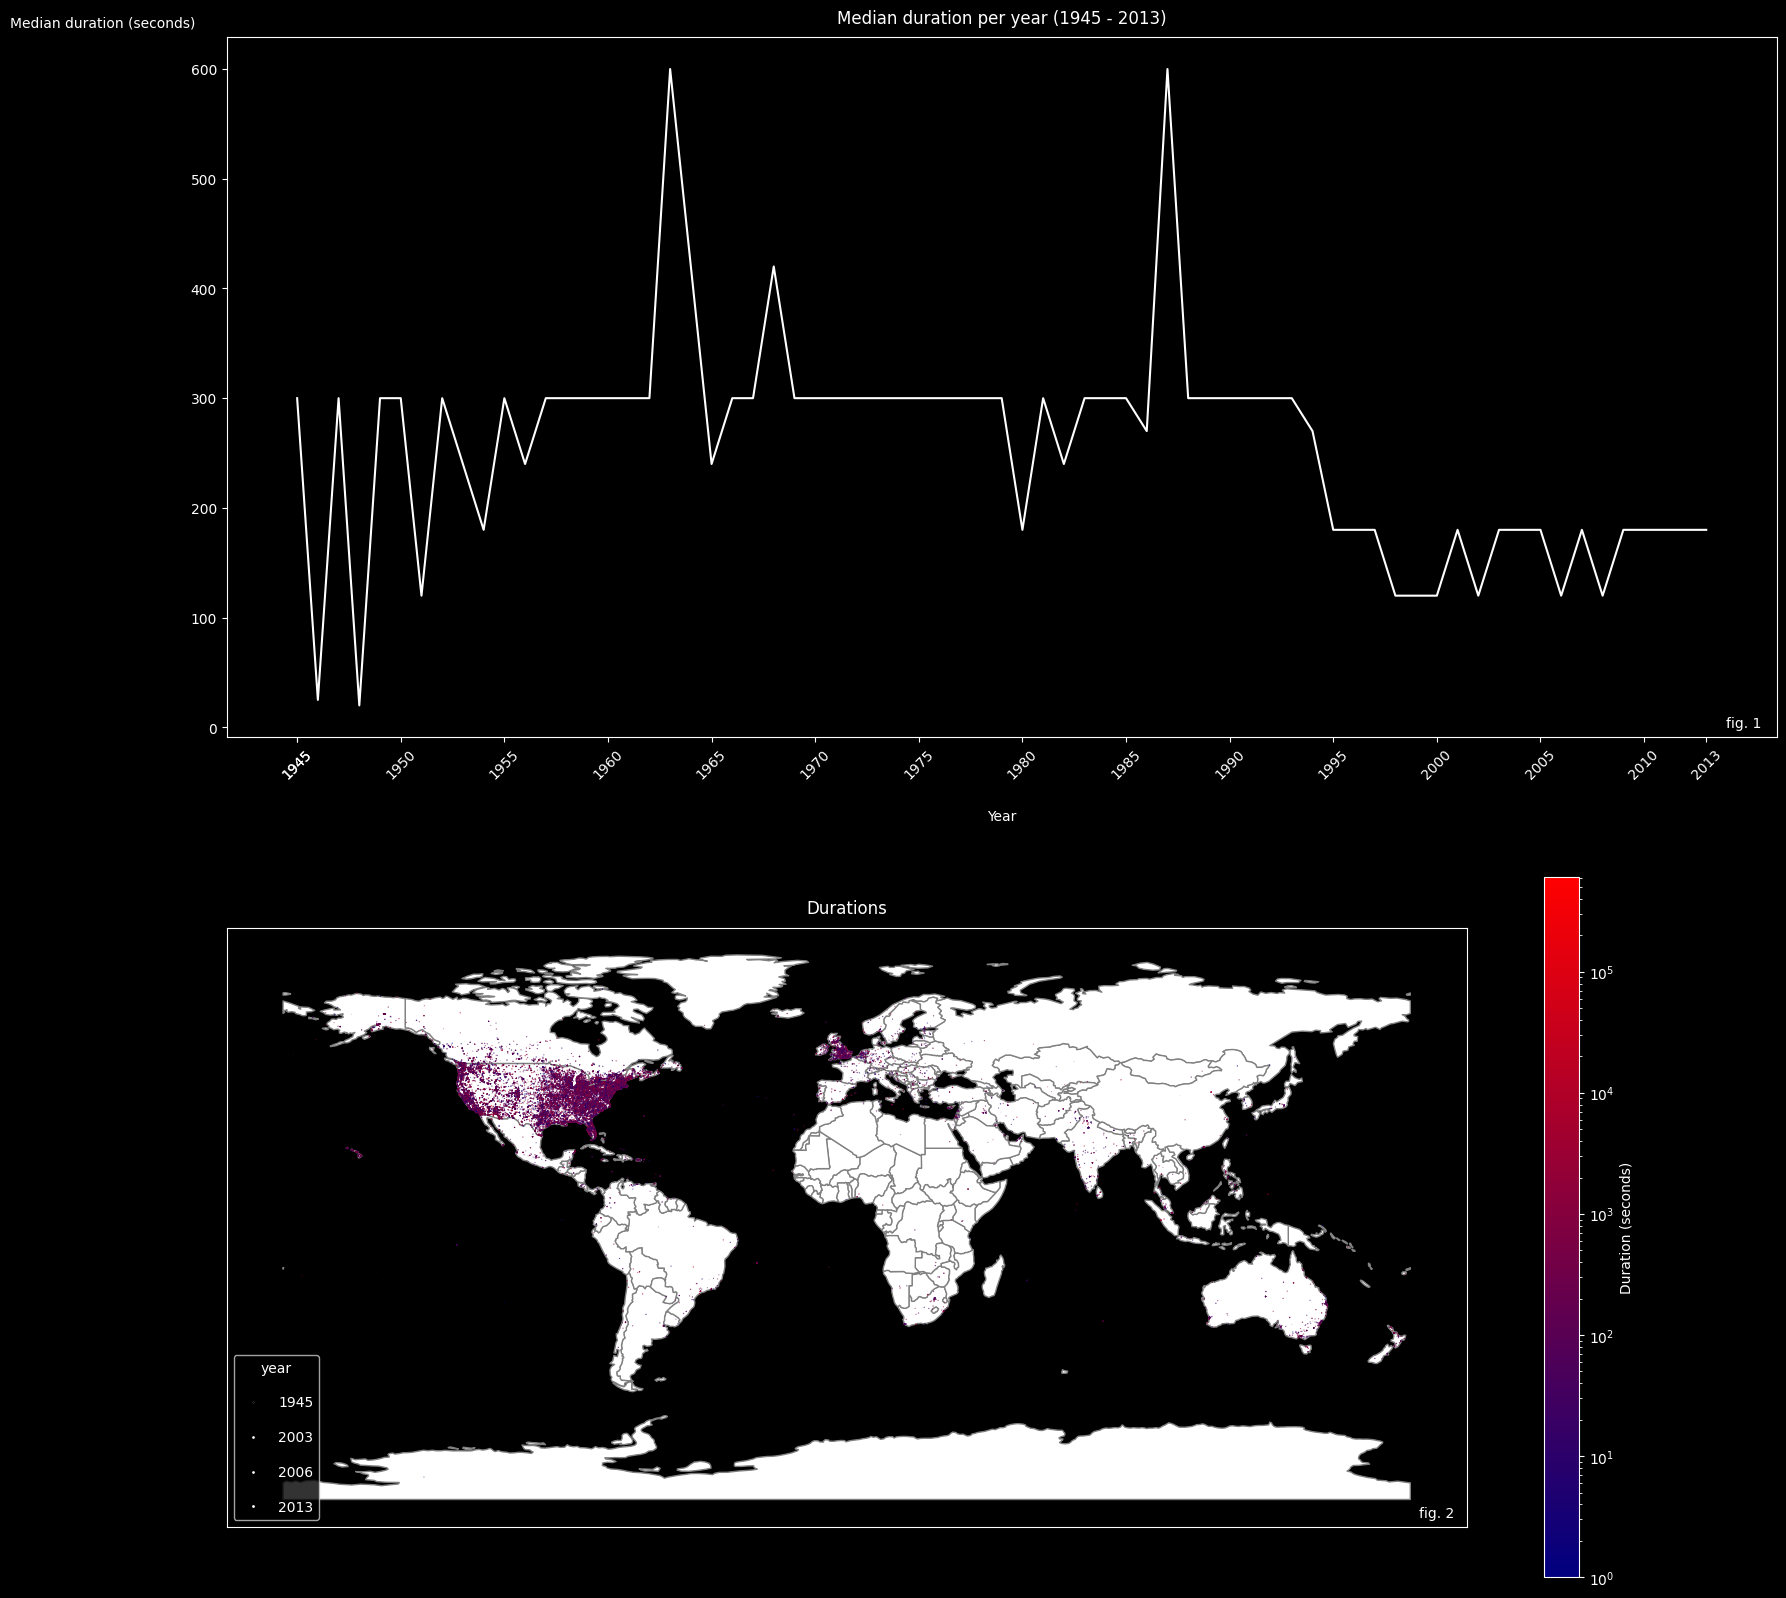

In [52]:

# duration not na and > 0
gdf_duration = df_geo[(df_geo['duration'].notna()) & (df_geo['duration'] > 0)]
# get durations by year
median_duration_year = get_duration_by_year(gdf_duration)
sorted_medians = median_duration_year.sort_values()

print(f'Minimal duration of a sighting: {gdf_duration['duration'].min()} second.')
print(f'Maximal duration of a sighting: {gdf_duration['duration'].max() / 60 / 60 / 24} days (limited).')

mean = gdf_duration['duration'].mean()
print(f'\nAverage duration of a sighting: {mean / 60 :.2f} minutes.')
median = gdf_duration['duration'].median()
print(f'Median duration of a sighting: {median / 60 :.2f} minutes.')
fq, tq = gdf_duration['duration'].quantile(.25), gdf_duration['duration'].quantile(.75)
print(f'First quartile duration of a sighting: {fq} seconds.')
print(f'Third quartile duration of a sighting: {tq / 60 :.2f} minutes.')
print(f'Interquartile range: {(tq - fq) / 60 :.2f} minutes.')
print(f'Standard deviation: {gdf_duration['duration'].std() / 60 / 60 :.2f} hours.')
print(f'Mean absolute deviation: {(gdf_duration['duration'] - mean).abs().mean() / 60:.2f} minutes.')
print(f'Median absolute deviation: {(gdf_duration['duration'] - median).abs().median() / 60 :.2f} minutes.')

print(f'\nYear with the lowest median: {(fi := sorted_medians.first_valid_index())} with {sorted_medians[fi]} seconds.')
print(f'Year with the highest median: {(li := sorted_medians.last_valid_index())} with {sorted_medians[li] / 60 :.2f} minutes.')

# create subplots
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

get_year_counts_graph(
    median_duration_year,
    ax1,
    'Median duration per year (1945 - 2013)',
    'fig. 1',
    ylabel='Median duration (seconds)'
)

# durations on map
place_durations_on_map(gdf_duration, world_map, ax2, 'Durations', 'fig. 2')

# save and display
save_and_display_plot('results/durations_map.png')

#del gdf_duration, df_geo, ax


## Comments graphics

In [157]:

# clean comments
def clean_comments(s: pd.Series) -> pd.Series :

    def clean_comment(comment: str) -> str :
        comment = comment.lower()
        comment = re.sub(r'[^\w\s]', ' ', comment)  # remove special charaters
        comment = re.sub(' +', ' ', comment)  # remove double spaces
        comment = ' '.join([word for word in comment.split() if word not in ENGLISH_STOP_WORDS])  # remove stop words
        return comment

    return s.apply(clean_comment)

# get word frequencies
def get_word_frequencies(s: pd.Series) -> pd.Series :

    words = (
        s.str.lower()  # lowercase
        .str.findall(r'\b[a-z]+\b')  # alphabetic tokens
        .explode()  # extract words
        .dropna()
    )

    # remove stop words
    words = words[~words.isin(ENGLISH_STOP_WORDS)]
    return words.value_counts()

# get comments info
def get_comments_info(df: pd.DataFrame) -> pd.DataFrame :

    new_df = df.copy()[df['comments'].notna()]
    # clean comments
    new_df['comments'] = clean_comments(new_df['comments'])
    # nb of chars
    new_df['char'] = new_df['comments'].str.len()
    # nb of words
    new_df['word'] = new_df['comments'].str.split().str.len()

    return new_df

# word cloud
def get_word_cloud(s: pd.Series, ax: Axes, title: str, label: str = '', *, mask_path: str | None = None) -> None :

    mask = None
    if mask_path is not None :
        mask = np.array(Image.open(mask_path).convert('L'))

    wc = WordCloud(
        width=800,
        height=600,
        background_color='black',
        mask=mask,
        colormap='plasma',
        contour_width=2 if mask is not None else 0,
        contour_color='white',
    ).generate(' '.join(s))


    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

    # figure label
    if label != '' :
        ax.text(
            .99, .01,
            label,
            transform=ax.transAxes,
            fontsize=10,
            va='bottom',
            ha='right',
        )


## Comment analysis

`Average` number of `characters` in a comment: **59.87 chars**.<br>
`Average` number of `words` in a comment: **9.71 words**.<br>
`Average` characters per word in comments: **6.16 chars**

The most frequent word is `light` (or `lights`) with **36072** occurrences, followed from far by `sky` with **17093** occurrences. We notice a descriptive trend of the observed object (like with `light` which is the most observed shape) with shapes (`shaped` with **7059** occurrences) and colors (`orange` (**8917**), `white` (**8131**), `red` (**7917**), ...) and its position (with `sky`) and its movements (`moving` with **9221** occurrences), or even comparisons (`like` with **5578** occurrences).

Average number of characters in comments: 59.87 chars.
Average number of words in comments: 9.71 words.
Average length of words in comments: 6.16 chars.

The 15 most frequent words in comments are:
word
light     18116
lights    17956
sky       17093
object    14812
bright    13326
moving     9221
orange     8917
white      8131
red        7917
shaped     7059
saw        6723
seen       5739
like       5578
craft      5437
ufo        5265
Name: count, dtype: int64


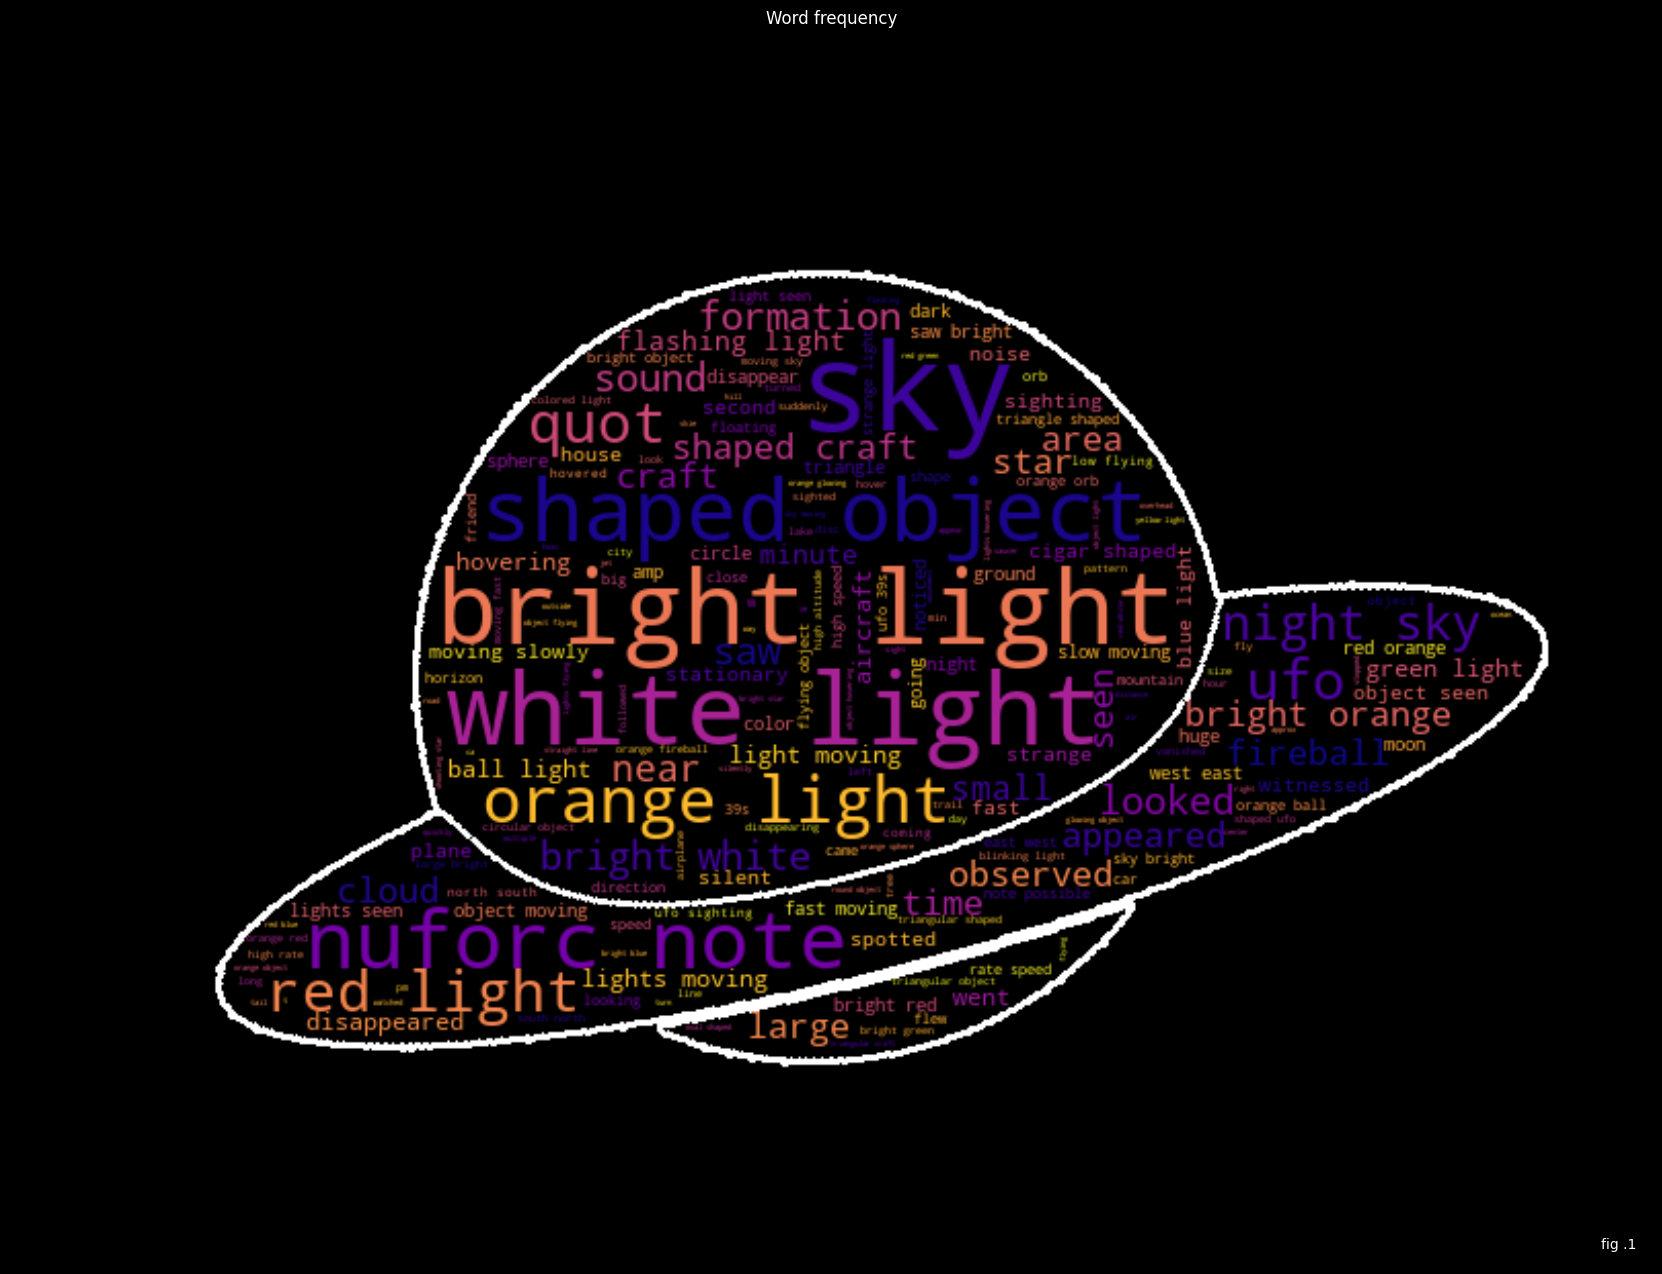

In [159]:

# word frequencies
wf = get_word_frequencies(clean_ufo['comments'].rename('word'))

# comments info
comments_df = get_comments_info(clean_ufo)

char_mean = comments_df['char'].mean()
print(f'Average number of characters in comments: {char_mean:.2f} chars.')
word_mean = comments_df['word'].mean()
print(f'Average number of words in comments: {word_mean:.2f} words.')
print(f'Average length of words in comments: {char_mean / word_mean :.2f} chars.')

print('\nThe 15 most frequent words in comments are:')
print_first_rows(wf, 15)

# create subplot
_, ax = plt.subplots(1, 1, figsize=(32, 16))

get_word_cloud(
    comments_df['comments'],
    ax,
    'Word frequency',
    'fig .1',
    mask_path=ufo_mask_path,
)

save_and_display_plot('results/comments.png')
